# unsafe.Pointer usage survey



In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import json
from datetime import datetime

In [18]:
MATCH_TYPES = (
    'unsafe.Pointer', 'unsafe.Sizeof', 'unsafe.Alignof', 'unsafe.Offsetof',
    'uintptr', 'reflect.SliceHeader', 'reflect.StringHeader'
)

## Analyse von Projektdaten

In [66]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S %z %Z')

projects_df = pd.read_csv('/home/johannes/studium/s14/masterarbeit/code/data-survey/data/projects.csv',
                         parse_dates=['project_created_at', 'project_last_pushed_at', 'project_updated_at'],
                         date_parser=dateparse)

In [32]:
projects_df[:5]

,project_rank,project_name,project_github_clone_url,project_number_of_stars,project_number_of_forks,project_github_id,project_created_at,project_last_pushed_at,project_updated_at,project_size,project_checkout_path
0,1,golang/go,https://github.com/golang/go.git,71169,10164,23096959,2014-08-19 04:33:40+00:00,2020-04-13 10:27:46+00:00,2020-04-13 11:58:18+00:00,209324,/home/johannes/studium/s14/masterarbeit/downlo...
1,2,kubernetes/kubernetes,https://github.com/kubernetes/kubernetes.git,64968,23144,20580498,2014-06-06 22:56:04+00:00,2020-04-13 11:53:02+00:00,2020-04-13 11:17:13+00:00,909251,/home/johannes/studium/s14/masterarbeit/downlo...
2,3,moby/moby,https://github.com/moby/moby.git,56804,16416,7691631,2013-01-18 18:10:57+00:00,2020-04-12 15:23:23+00:00,2020-04-13 12:00:24+00:00,152827,/home/johannes/studium/s14/masterarbeit/downlo...
3,4,avelino/awesome-go,https://github.com/avelino/awesome-go.git,53411,7088,21540759,2014-07-06 13:42:15+00:00,2020-04-13 09:42:24+00:00,2020-04-13 11:56:14+00:00,8027,/home/johannes/studium/s14/masterarbeit/downlo...
4,5,gohugoio/hugo,https://github.com/gohugoio/hugo.git,43140,4900,11180687,2013-07-04 15:26:26+00:00,2020-04-12 19:12:47+00:00,2020-04-13 11:52:14+00:00,86013,/home/johannes/studium/s14/masterarbeit/downlo...


## Analyse von Match Daten

In [68]:
matches_df = pd.read_csv('/home/johannes/studium/s14/masterarbeit/code/data-survey/backup-data/unsafe_matches_2.csv')

In [69]:
matches_df

,project_name,module_import_path,module_registry,module_version,module_number_go_files,file_name,file_size_bytes,file_size_lines,file_imports_unsage_pkg,file_go_vet_output,text,context,line_number,byte_offset,match_type
0,kubernetes/kubernetes,github.com/Azure/go-ansiterm,github.com,NaN,22,winterm/api.go,12469,327,True,NOT-RUN,"\tr1, r2, err := getConsoleCursorInfoProc.Call...",}\n\n// GetConsoleCursorInfo retrieves informa...,178,6018,unsafe.Pointer
1,kubernetes/kubernetes,github.com/Azure/go-ansiterm,github.com,NaN,22,winterm/api.go,12469,327,True,NOT-RUN,"\tr1, r2, err := setConsoleCursorInfoProc.Call...",}\n\n// SetConsoleCursorInfo sets the size and...,185,6393,unsafe.Pointer
2,kubernetes/kubernetes,github.com/Azure/go-ansiterm,github.com,NaN,22,winterm/api.go,12469,327,True,NOT-RUN,\terr := checkError(getConsoleScreenBufferInfo...,\n// GetConsoleScreenBufferInfo retrieves info...,216,7792,unsafe.Pointer
3,kubernetes/kubernetes,github.com/Azure/go-ansiterm,github.com,NaN,22,winterm/api.go,12469,327,True,NOT-RUN,"\tr1, r2, err := scrollConsoleScreenBufferProc...","\t}\n\treturn &info, nil\n}\n\nfunc ScrollCons...",224,8084,unsafe.Pointer
4,kubernetes/kubernetes,github.com/Azure/go-ansiterm,github.com,NaN,22,winterm/api.go,12469,327,True,NOT-RUN,"\tr1, r2, err := setConsoleWindowInfoProc.Call...",\n// SetConsoleWindowInfo sets the size and po...,253,9532,unsafe.Pointer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140340,ethereum/go-ethereum,github.com/mattn/go-colorable,github.com,NaN,4,colorable_windows.go,23106,980,True,NOT-RUN,\t\t\tprocGetConsoleScreenBufferInfo.Call(uint...,\t\t\t}\n\t\t\tprocGetConsoleScreenBufferInfo....,564,11887,uintptr
140341,ethereum/go-ethereum,github.com/mattn/go-colorable,github.com,NaN,4,colorable_windows.go,23106,980,True,NOT-RUN,\t\t\tprocSetConsoleCursorPosition.Call(uintpt...,\t\t\t\t\tcsbi.cursorPosition.y = short(n1 - 1...,589,12519,uintptr
140342,ethereum/go-ethereum,github.com/mattn/go-colorable,github.com,NaN,4,colorable_windows.go,23106,980,True,NOT-RUN,\t\t\tprocGetConsoleScreenBufferInfo.Call(uint...,\t\t\t\t\tcontinue\n\t\t\t\t}\n\t\t\t}\n\t\t\t...,600,12801,uintptr
140343,ethereum/go-ethereum,github.com/mattn/go-colorable,github.com,NaN,4,colorable_windows.go,23106,980,True,NOT-RUN,\t\t\tprocFillConsoleOutputCharacter.Call(uint...,\t\t\t\tcount = dword(csbi.size.x) - dword(csb...,612,13508,uintptr


In [70]:
# 10 examples of an unsafe.Pointer match

print("\n\n".join([s.strip() for s in list(matches_df['text'][:10])]))

r1, r2, err := getConsoleCursorInfoProc.Call(handle, uintptr(unsafe.Pointer(cursorInfo)), 0)

r1, r2, err := setConsoleCursorInfoProc.Call(handle, uintptr(unsafe.Pointer(cursorInfo)), 0)

err := checkError(getConsoleScreenBufferInfoProc.Call(handle, uintptr(unsafe.Pointer(&info)), 0))

r1, r2, err := scrollConsoleScreenBufferProc.Call(handle, uintptr(unsafe.Pointer(&scrollRect)), uintptr(unsafe.Pointer(&clipRect)), coordToPointer(destOrigin), uintptr(unsafe.Pointer(&char)))

r1, r2, err := setConsoleWindowInfoProc.Call(handle, uintptr(boolToBOOL(isAbsolute)), uintptr(unsafe.Pointer(&rect)))

r1, r2, err := writeConsoleOutputProc.Call(handle, uintptr(unsafe.Pointer(&buffer[0])), coordToPointer(bufferSize), coordToPointer(bufferCoord), uintptr(unsafe.Pointer(writeRegion)))

r1, r2, err := readConsoleInputProc.Call(handle, uintptr(unsafe.Pointer(&buffer[0])), uintptr(len(buffer)), uintptr(unsafe.Pointer(count)))

return uintptr(*((*uint32)(unsafe.Pointer(&c))))

func GetConsoleCursorInfo(

In [71]:
# 1 example of a match context

print(matches_df['context'][0])

}

// GetConsoleCursorInfo retrieves information about the size and visiblity of the console cursor.
// See https://msdn.microsoft.com/en-us/library/windows/desktop/ms683163(v=vs.85).aspx.
func GetConsoleCursorInfo(handle uintptr, cursorInfo *CONSOLE_CURSOR_INFO) error {
	r1, r2, err := getConsoleCursorInfoProc.Call(handle, uintptr(unsafe.Pointer(cursorInfo)), 0)
	return checkError(r1, r2, err)
}

// SetConsoleCursorInfo sets the size and visiblity of the console cursor.
// See https://msdn.microsoft.com/en-us/library/windows/desktop/ms686019(v=vs.85).aspx.



## Analyse von Moduldaten

In [54]:
modules_df = pd.read_csv('/home/johannes/studium/s14/masterarbeit/code/data-survey/backup-data/modules.csv')

In [55]:
modules_df

,project_name,module_import_path,module_registry,module_version,module_number_go_files
0,kubernetes/kubernetes,bitbucket.org/bertimus9/systemstat,bitbucket.org,NaN,4
1,kubernetes/kubernetes,cloud.google.com/go/compute/metadata,cloud.google.com,NaN,1
2,kubernetes/kubernetes,github.com/armon/circbuf,github.com,NaN,1
3,kubernetes/kubernetes,github.com/asaskevich/govalidator,github.com,NaN,8
4,kubernetes/kubernetes,github.com/aws/aws-sdk-go/aws,github.com,NaN,86
...,...,...,...,...,...
2354,gogs/gogs,gopkg.in/gomail.v2,gopkg.in,NaN,8
2355,gogs/gogs,gopkg.in/ini.v1,gopkg.in,NaN,10
2356,gogs/gogs,gopkg.in/ldap.v2,gopkg.in,NaN,18
2357,gogs/gogs,gopkg.in/macaron.v1,gopkg.in,NaN,12


# Auswertungen

## Anzahl von unsafe usages nach Projekt

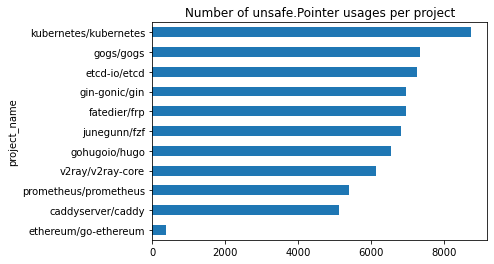

In [122]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=True).plot.barh(title='Number of unsafe.Pointer usages per project')

## Anzahl von unsafe usages nach Modul

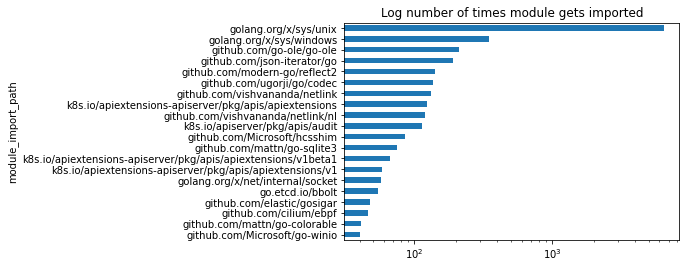

In [218]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .groupby(['module_import_path', 'project_name'])['module_import_path'].count()\
    .groupby('module_import_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(logx=True, title='Log number of unsafe.Pointer usages per module')

In [219]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .groupby(['module_import_path', 'project_name'])['module_import_path'].count()\
    .groupby('module_import_path').max()\
    .sort_values(ascending=False)[:15]

module_import_path
golang.org/x/sys/unix                                            6466
golang.org/x/sys/windows                                          346
github.com/go-ole/go-ole                                          211
github.com/json-iterator/go                                       191
github.com/modern-go/reflect2                                     142
github.com/ugorji/go/codec                                        137
github.com/vishvananda/netlink                                    131
k8s.io/apiextensions-apiserver/pkg/apis/apiextensions             124
github.com/vishvananda/netlink/nl                                 119
k8s.io/apiserver/pkg/apis/audit                                   114
github.com/Microsoft/hcsshim                                       86
github.com/mattn/go-sqlite3                                        75
k8s.io/apiextensions-apiserver/pkg/apis/apiextensions/v1beta1      66
k8s.io/apiextensions-apiserver/pkg/apis/apiextensions/v1           58
g

Wir sehen einen unglaublich großen Vorsprung des `sys` Packages, das durch sehr viele Wrapper-Calls um C-Library Funktionen kommt. Dieses Paket sollte bei Analysen vielleicht ausgenommen werden.

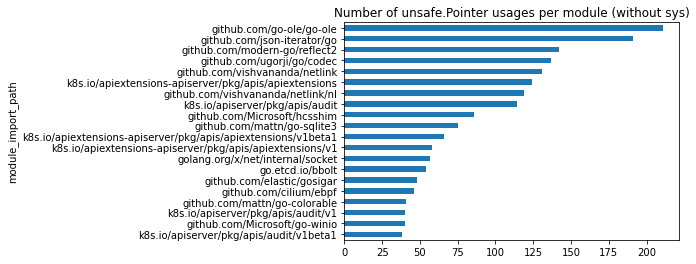

In [258]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .where(matches_df['module_import_path']!='golang.org/x/sys/unix')\
    .where(matches_df['module_import_path']!='golang.org/x/sys/windows')\
    .groupby(['module_import_path', 'project_name'])['module_import_path'].count()\
    .groupby('module_import_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Number of unsafe.Pointer usages per module (without sys)')

## Anzahl von unsafe.Pointer usages pro Registry

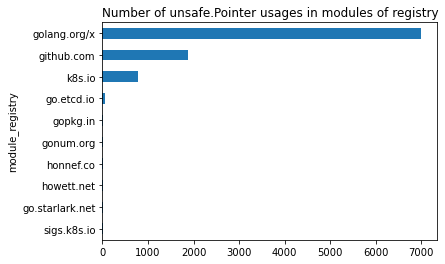

In [259]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .groupby(['module_registry', 'module_import_path', 'project_name'])['module_registry'].count()\
    .groupby(['module_registry', 'module_import_path']).max()\
    .groupby('module_registry').sum()\
    .sort_values(ascending=True).plot.barh(title='Number of unsafe.Pointer usages in modules of registry')

In [237]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .groupby(['module_registry', 'module_import_path', 'project_name'])['module_registry'].count()\
    .groupby(['module_registry', 'module_import_path']).max()\
    .groupby('module_registry').sum()\
    .sort_values(ascending=False)

module_registry
golang.org/x       7006
github.com         1872
k8s.io              773
go.etcd.io           58
gopkg.in             14
gonum.org             8
honnef.co             7
howett.net            2
go.starlark.net       2
sigs.k8s.io           1
Name: module_registry, dtype: int64

Wir sehen eine riesige Häufung in der `golang.org/x` Registry, die allerdings nur durch das `sys` Package erzeugt wird.

## Unterschiedliche Anzahl von unsafe.Pointer usages in der gleichen Bibliothek

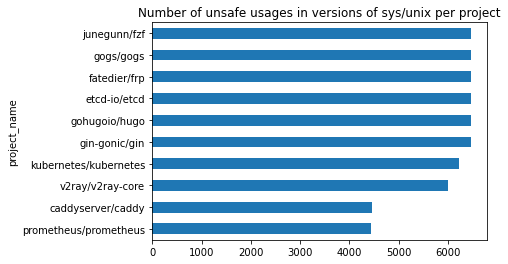

In [239]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .where(matches_df['module_import_path']=='golang.org/x/sys/unix')\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=True).plot.barh(title='Number of unsafe usages in versions of sys/unix per project')

In [247]:
matches_df\
    .where(matches_df['match_type']=='unsafe.Pointer')\
    .where(matches_df['module_import_path']=='golang.org/x/sys/unix')\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=False)

project_name
junegunn/fzf             6466
gogs/gogs                6466
fatedier/frp             6466
etcd-io/etcd             6466
gohugoio/hugo            6462
gin-gonic/gin            6460
kubernetes/kubernetes    6216
v2ray/v2ray-core         5990
caddyserver/caddy        4451
prometheus/prometheus    4438
Name: project_name, dtype: int64

Mögliche Gründe:

 - nicht alle Dateien des Moduls werden von `go mod vendor` kopiert, sondern nur die benötigten
 - es handelt sich um unterschiedliche Versionen von sys/unix

## Anzahl von unsafe.Pointer usages pro Datei

## Wie oft werden Module importiert? (Beliebtheit)

## Verteilung unsafe.Pointer usage auf Stars/Forks/LastPushAge

## Prozentsatz von unsafe.Pointer nutzenden Dateien pro Modul

## Verteilung von unsafe auf verschiedene match types

## Vet Ergebnisse pro Modul

## Vet Ergebnisse pro Projekt

## Vet Ergebnisse im Zusammenhang mit unsafe

## Anzahl unsafe.Pointer usages, die von Vet erkannt wurden

## Scratch Space

In [246]:
"Hi"

'Hi'